In [ ]:
from pyvela import SPNTA
from pyvela.fitter import VelaFitter

from pint.models import get_model_and_toas
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt

## The SPNTA class (kind of general API)

In [18]:
spnta = SPNTA (
    parfile ="NGC6440E.par",
    timfile ="NGC6440E.tim",
    cheat_prior_scale=100,
    # custom_priors="NGC6440E_priors.json",
    # custom_priors={ ... },
)

In [19]:
nwalkers = spnta.ndim * 5
p0 = np.array([
    spnta.prior_transform(cube)
    for cube in np.random.rand(nwalkers, spnta.ndim)
])

In [20]:
spnta.lnpost_vectorized(p0)

40-element Vector{Float64}:
      -1.9323020820776138e6
  -58924.81871563387
 -453216.7202400749
      -3.795880047721362e6
 -491243.29233732086
      -2.1546533002824658e6
      -4.425335182963319e6
      -3.775521573417118e6
      -6.531794642693984e6
 -769414.7133865969
       ⋮
      -4.66457610520357e6
      -1.895946984100577e6
 -870832.394753085
  -50258.95175376438
      -1.8805989111960833e6
   -6460.099123547296
      -4.784214459619898e6
 -114505.1570104974
  -43353.389648612516

In [22]:
sampler = emcee.EnsembleSampler(
    nwalkers,
    spnta.ndim,
    spnta.lnpost_vectorized,
    vectorize=True,
)

In [23]:
sampler.run_mcmc(p0, 4000, progress=True);

100%|██████████| 4000/4000 [00:05<00:00, 785.25it/s]


In [24]:
samples_raw = sampler.get_chain(flat=True, discard=1000, thin=50)
samples = spnta.rescale_samples(samples_raw)

In [9]:
F_ = spnta.model.param_handler._default_params_tuple.F_.x
shifts = np.array([0 if pname != "F0" else F_ for pname in spnta.param_names])

In [26]:
params_med_raw = np.median(samples_raw, axis=0)
params_med = spnta.rescale_samples(params_med_raw)
params_std = np.std(samples, axis=0)

print(f"Param\t{'Unit':<15}{'Value':<33}Uncertanties")
print("-" * 77)
for pname, punit, pval, pstd in zip(spnta.param_names, spnta.param_units, (params_med + shifts), params_std):
    print(f"{pname}\t{punit:<15}{pval}\t+/-\t{pstd}")

Param	Unit           Value                            Uncertanties
-----------------------------------------------------------------------------
RAJ	hourangle      17.81466676674083	+/-	4.047294529120308e-08
DECJ	deg            -20.35816230932348	+/-	9.884515509002506e-06
PHOFF	1              0.09842280320176441	+/-	0.0004615840284586919
DM	pc / cm3       224.11324896472144	+/-	0.03603360420846229
F0	Hz             61.48547655436999	+/-	1.9137091933485957e-11
F1	Hz / s         -1.1812327460531614e-15	+/-	1.5319605711454056e-18
EFAC1	1              1.0267406113827753	+/-	0.10414514962939878
EQUAD1	us             0.29656356266064127	+/-	4.629080165826282


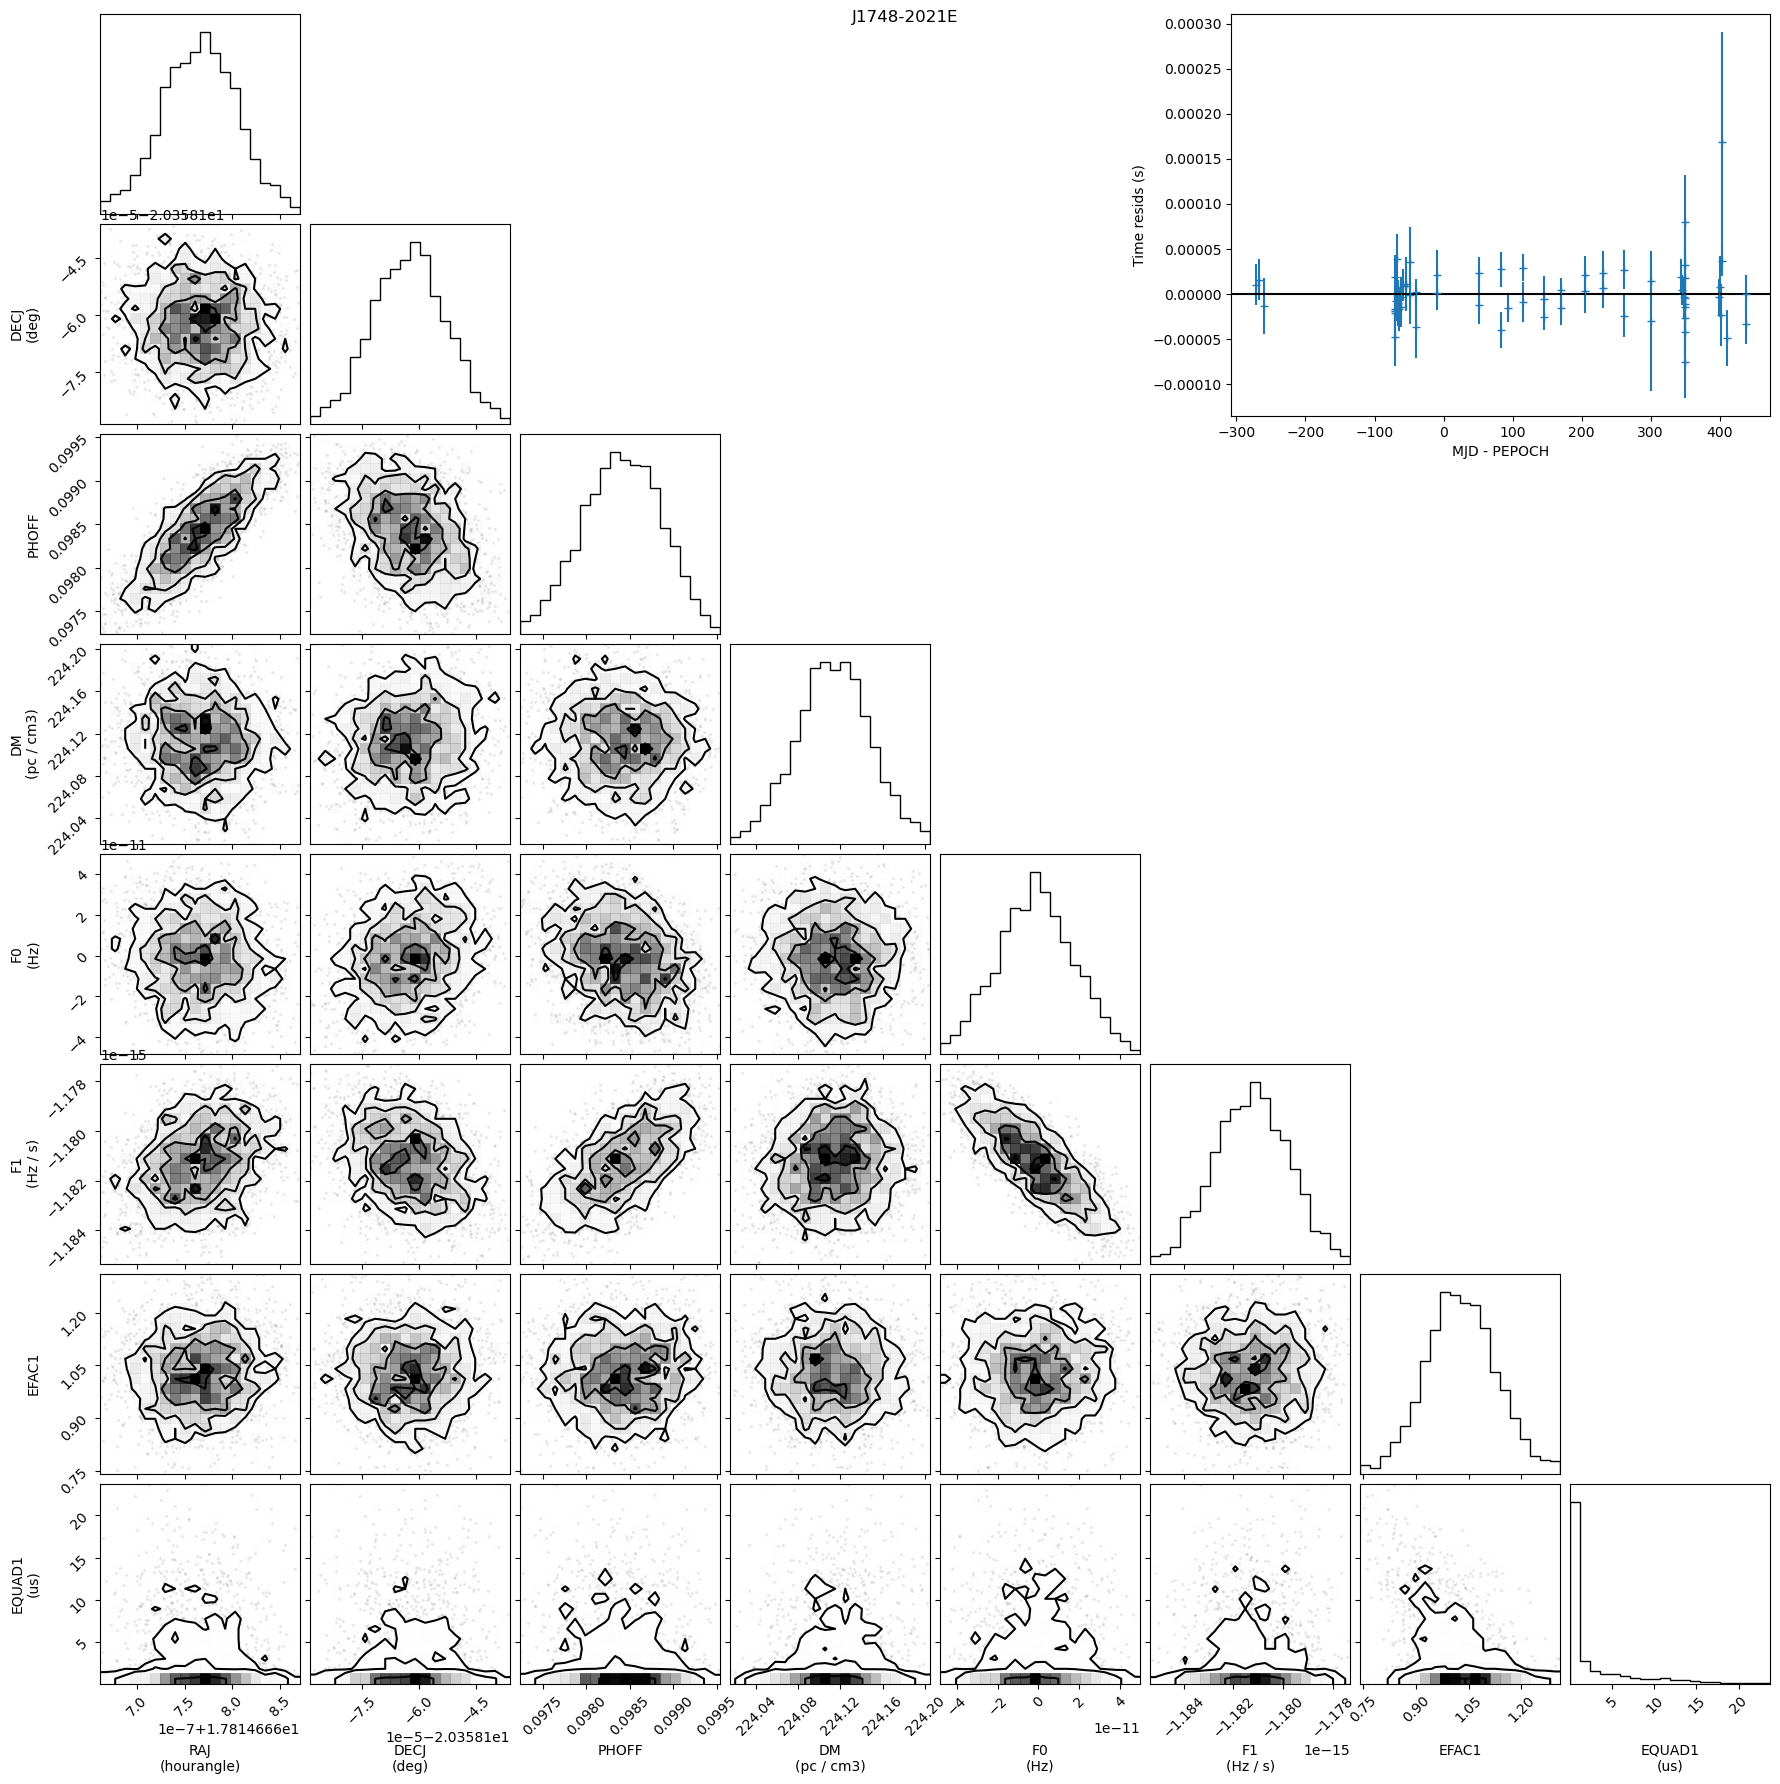

In [27]:
fig = corner.corner(
    samples,
    labels=spnta.param_labels,
    range=[0.99]*spnta.ndim
)

plt.subplot(433)
plt.errorbar(spnta.mjds, spnta.time_residuals(params_med_raw), spnta.scaled_toa_unceritainties(params_med_raw), ls="", marker="+")
plt.xlabel("MJD - PEPOCH")
plt.ylabel("Time resids (s)")
plt.axhline(0, color="k")

plt.suptitle(spnta.model.pulsar_name);

## pyvela command line interface

In [ ]:
# pyvela J0613-0200.InPTA.NB.par J0613-0200.InPTA.NB.tim -o J0613-0200.InPTA.NB_out -M -C 100 -f
# pyvela-plot J0613-0200.InPTA.NB_out

## VelaFitter

In [28]:
m, t = get_model_and_toas("NGC6440E.par", "NGC6440E.tim", planets=True)

In [29]:
ftr = VelaFitter(
    t, 
    m,
    cheat_prior_scale=100,
    # custom_priors="..."
    # custom_priors={ ... }
)

In [30]:
ftr.fit_toas()

  0%|          | 0/6000 [00:00<?, ?it/s]

100%|██████████| 6000/6000 [00:35<00:00, 169.76it/s]


In [31]:
print(ftr.model)

# Created: 2025-04-24T21:49:19.404972
# PINT_version: 1.1.1+170.g68c9a01e
# User: Abhimanyu Susobhanan (abhimanyu)
# Host: abhimanyu-HP-Envy-x360-2-in-1-Laptop-15-fh0xxx
# OS: Linux-6.8.0-58-generic-x86_64-with-glibc2.39
# Python: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]
# Format: pint
# read_time: 2025-04-24T21:44:07.349968
# allow_tcb: False
# convert_tcb: False
# allow_T2: False
# original_name: NGC6440E.par
PSR                           J1748-2021E
EPHEM                               DE440
CLK                          TT(BIPM2021)
UNITS                                 TDB
START              53478.2858714195382639
FINISH             54187.5873241702319097
TIMEEPH                              FB90
T2CMETHOD                        IAU2000B
DILATEFREQ                              N
DMDATA                                  N
NTOA                                   62
CHI2                   62.000000016428395
CHI2R                  1.1481481484523777
TR